<h1>Steps 1 and 2: Finding the Problem and Gathering Data (Inspired by <a>
    https://www.kaggle.com/code/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy</a>)</h1>
    <p> Luckily these are provided to Kaggle for free, so no need to worry about it. </p>

<h1> Step 3: Data Extraction and Cleaning </h1>

<h2> Step 3.0: Importing Useful Packages </h2>

In [1]:
#Importing Useful Packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn

#ml models
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

#preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

#feature importance
from sklearn import inspection

#Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

import time
import warnings
warnings.filterwarnings('ignore')
print('-'*25)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


-------------------------
/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


<h2> Step 3.1: Understanding the Data </h2>

In [2]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
total_data = [train_data, test_data]
train_data.sample(10)
#test_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
485,486,0,3,"Lefebre, Miss. Jeannie",female,NaN,3,1,4133,25.4667,NaN,S
577,578,1,1,"Silvey, Mrs. William Baird (Alice Munger)",female,39.0,1,0,13507,55.9000,E44,S
660,661,1,1,"Frauenthal, Dr. Henry William",male,50.0,2,0,PC 17611,133.6500,NaN,S
293,294,0,3,"Haas, Miss. Aloisia",female,24.0,0,0,349236,8.8500,NaN,S
502,503,0,3,"O'Sullivan, Miss. Bridget Mary",female,NaN,0,0,330909,7.6292,NaN,Q
634,635,0,3,"Skoog, Miss. Mabel",female,9.0,3,2,347088,27.9000,NaN,S
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
795,796,0,2,"Otter, Mr. Richard",male,39.0,0,0,28213,13.0000,NaN,S
474,475,0,3,"Strandberg, Miss. Ida Sofia",female,22.0,0,0,7553,9.8375,NaN,S
318,319,1,1,"Wick, Miss. Mary Natalie",female,31.0,0,2,36928,164.8667,C7,S


Some things to note about this data:
<ul>
    <li> This data is tabular, meaning that we can build simple linear/logistic regression models, or tree based algorithms (decision trees, random forest, gradient boosting), SVMs, k-NN, or Neural Networks. Ideally we can try ensembling these models and put a popular vote. </li>
    <li> PassengerId and Ticket: The ID of each Passsenger, probably not useful for determine who survives or not. Similarly, Ticket probably does not provide any useful data. </li>
    <li> Survived: The main thing we want to determine. </li>
    <li> Pclass (Passenger Class): 1 = upper class, 2 = middle class, 3 = lower class. Potentially useful data. </li> 
    <li> Name: Probably not that important, so we'll ignore that. You can however feature engineer some data from the name, but that's advanced. </li>
    <li> Sex: Likely important, converted into an encoding to use </li>
    <li> Age: Also potentially important </li>
    <li> SibSp and Parch (The number of related Siblings/Spouse aboard): Could be potentially important </li>
    <li> Fare: Could be potentially important </li>
    <li> Cabin: Might be useful for feature engineering, but there's too many null values to be useful </li>
    <li> Embarked (where the passenger embarked from): Also might be potentially useful. </li>
    

In [3]:
#Checking how many columns have null values
print('Training Data columns with null values:\n', train_data.isnull().sum())
print('-'*12)
print('Testing data columns with null values:\n', test_data.isnull().sum())

Training Data columns with null values:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
------------
Testing data columns with null values:
 PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


<h2> Step 3.2: Cleaning Data </h2>
We need to correct, complete (if missing null values), create data (from feature extraction), and convert categorical variables into something useful (via encoding.)
Given the sample above, the data provided looks reasonable, so we can move to completing missing null values.

In [4]:
#For advanced data cleaning, we could use the other data and try to infer 
#age, fare and embarking. Cabin has too little data to be useful.
#For now, we can just fill age with median (because it's a discrete variable),
#fare with median (because mean is prone to outliers)
#embarking with mode 
#for dataset in total_data: #fillna replaces null values with value specified
#    dataset['Age'].fillna(dataset['Age'].median(), inplace = True)
#    dataset['Fare'].fillna(dataset['Fare'].median(), inplace = True)
#    #print(dataset['Embarked'].mode)
#    dataset['Embarked'].fillna(dataset['Embarked'].mode(), inplace = True)

#smarter feature engineering
#age is correlated to pclass and title, therefore we use gender and pclass data to fill in age
for dataset in total_data:
    dataset['Age'] = dataset.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))
    dataset['Embarked'] = dataset['Embarked'].fillna('S') #doing some research on missing embarked person
    #fare has a strong correlation with Pclass and IsAlone/FamilySize
    #only one passenger with a pclass 3 ticket and is alone has no fare, therefore we fill accordingly
    med_fare = dataset.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]
    dataset['Fare'] = dataset['Fare'].fillna(med_fare)

#drops the unused columns for the training data
drop_column = ['PassengerId']
train_data.drop(drop_column,axis=1,inplace=True) #1st axis = col

print(train_data.isnull().sum())
print("-"*12)
print(test_data.isnull().sum())

Survived      0
Pclass        0
Name          0
Sex           0
Age           0
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      0
dtype: int64
------------
PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64


In [5]:
#Creating new groups
for dataset in total_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    dataset['IsAlone'] = 1 #initialize to yes/1 is alone -> check for correlations
    dataset.loc[dataset['FamilySize'] > 1, 'IsAlone'] = 0 # now update to no/0 if family size is greater than 1

    dataset['Ticket_Frequency'] = dataset.groupby('Ticket')['Ticket'].transform('count')
    
    family_map = {1: 'Alone', 2: 'Small', 3: 'Small', 4: 'Small', 5: 'Medium', 6: 'Medium', 7: 'Large', 8: 'Large', 11: 'Large'}
    dataset['FamilySizeGrouped'] = dataset['FamilySize'].map(family_map)
    
    #added variable bins (qcut = frequency bins, cut = value bins)
    dataset['FareBin'] = pd.qcut(dataset['Fare'], 10)
    dataset['AgeBin'] = pd.cut(dataset['Age'].astype('int'), 10)
    
    #added titles 
    dataset['Title'] = dataset['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
    
    #cleanup title dataset (grouping less occurring titles together)
    dataset['Title'] = dataset['Title'].replace(['Miss', 'Ms', 'Mlle', 'Lady', 'Mme', 'the Countess', 'Dona'], 'Miss/Ms')
    dataset['Title'] = dataset['Title'].replace(['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'], 'Dr/Military/Noble/Clergy')

    #cabin dataset
    dataset['Deck'] = dataset['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')
    #idx = dataset[dataset['Deck'] == 'T'].index
    #dataset.loc[idx, 'Deck'] = 'A'
    
    dataset['Deck'] = dataset['Deck'].replace(['A', 'B', 'C', 'T'], 'ABC')
    dataset['Deck'] = dataset['Deck'].replace(['D', 'E'], 'DE')
    dataset['Deck'] = dataset['Deck'].replace(['F', 'G'], 'FG')
    
    dataset['Young_Person'] = dataset['Age'].apply(lambda age: 1 if age < 18 else 0)

idx = train_data[train_data['Deck'] == 'T'].index
train_data.loc[idx, 'Deck'] = 'ABC'

print(train_data['Deck'].value_counts())    
print(train_data['Title'].value_counts())

train_data.sample(10)

M      687
ABC    122
DE      65
FG      17
Name: Deck, dtype: int64
Mr                          517
Miss/Ms                     188
Mrs                         125
Master                       40
Dr/Military/Noble/Clergy     21
Name: Title, dtype: int64


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,IsAlone,Ticket_Frequency,FamilySizeGrouped,FareBin,AgeBin,Title,Deck,Young_Person
313,0,3,"Hendekovic, Mr. Ignjac",male,28.0,0,0,349243,7.8958,NaN,S,1,1,1,Alone,"(7.854, 8.05]","(24.0, 32.0]",Mr,M,0
605,0,3,"Lindell, Mr. Edvard Bengtsson",male,36.0,1,0,349910,15.5500,NaN,S,2,0,1,Small,"(14.454, 21.679]","(32.0, 40.0]",Mr,M,0
418,0,2,"Matthews, Mr. William John",male,30.0,0,0,28228,13.0000,NaN,S,1,1,1,Alone,"(10.5, 14.454]","(24.0, 32.0]",Mr,M,0
108,0,3,"Rekic, Mr. Tido",male,38.0,0,0,349249,7.8958,NaN,S,1,1,1,Alone,"(7.854, 8.05]","(32.0, 40.0]",Mr,M,0
484,1,1,"Bishop, Mr. Dickinson H",male,25.0,1,0,11967,91.0792,B49,C,2,0,2,Small,"(77.958, 512.329]","(24.0, 32.0]",Mr,ABC,0
866,1,2,"Duran y More, Miss. Asuncion",female,27.0,1,0,SC/PARIS 2149,13.8583,NaN,C,2,0,1,Small,"(10.5, 14.454]","(24.0, 32.0]",Miss/Ms,M,0
610,0,3,"Andersson, Mrs. Anders Johan (Alfrida Konstant...",female,39.0,1,5,347082,31.2750,NaN,S,7,0,7,Large,"(27.0, 39.688]","(32.0, 40.0]",Mrs,M,0
701,1,1,"Silverthorne, Mr. Spencer Victor",male,35.0,0,0,PC 17475,26.2875,E24,S,1,1,1,Alone,"(21.679, 27.0]","(32.0, 40.0]",Mr,DE,0
59,0,3,"Goodwin, Master. William Frederick",male,11.0,5,2,CA 2144,46.9000,NaN,S,8,0,6,Large,"(39.688, 77.958]","(8.0, 16.0]",Master,M,1
13,0,3,"Andersson, Mr. Anders Johan",male,39.0,1,5,347082,31.2750,NaN,S,7,0,7,Large,"(27.0, 39.688]","(32.0, 40.0]",Mr,M,0


In [6]:
#CONVERT: Converting Categorical variables into more useful information
label = LabelEncoder()
one_hot = OneHotEncoder()
for i, dataset in enumerate(total_data):
    #dataset['Embarked_Code'] = one_hot.fit_transform(dataset['Embarked'].values.reshape(-1,1)).toarray()
    #dataset['Title_Code'] = one_hot.fit_transform(dataset['Title'].values.reshape(-1,1)).toarray()
    #using fit_transform because numbers are connected
    dataset['AgeBin_Code'] = label.fit_transform(dataset['AgeBin'])
    dataset['FareBin_Code'] = label.fit_transform(dataset['FareBin'])
    dataset['Sex_Code'] = label.fit_transform(dataset['Sex'])
    #dataset['Embarked_Code'] = label.fit_transform(dataset['Embarked
    
    
y = ['Survived']
#train_x = ['Title', 'Sex','Pclass', 'Embarked', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone'] 
train_x = ['FamilySizeGrouped', 'Deck']
#train_x = ['Title', 'FamilySizeGrouped']
train_xy = train_x + y
#removes continuous variables
train_x_bin = ['Sex_Code', 'Young_Person']
#train_x_bin = ['Sex_Code', 'Pclass', 'Ticket_Frequency']
train_xy_bin = train_x_bin + y

#get dummies
train_dummy = pd.get_dummies(train_data[train_x])
train_x_dummy = train_dummy.columns.tolist()
train_xy_dummy = train_x_dummy + y
test_dummy = pd.get_dummies(test_data[train_x])

#use one-hot-encodings on train_data
train_data = pd.concat([train_data, train_dummy], axis=1)
train_x_bin = train_x_bin + train_x_dummy
test_data = pd.concat([test_data, test_dummy], axis=1)

#print(train_x_bin)

train_data.head()
#train_dummy.head()
#test_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,FareBin_Code,Sex_Code,FamilySizeGrouped_Alone,FamilySizeGrouped_Large,FamilySizeGrouped_Medium,FamilySizeGrouped_Small,Deck_ABC,Deck_DE,Deck_FG,Deck_M
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,...,0,1,0,0,0,1,0,0,0,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,...,8,0,0,0,0,1,1,0,0,0
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,...,2,0,1,0,0,0,0,0,0,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,...,8,0,0,0,0,1,1,0,0,0
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,...,2,1,1,0,0,0,0,0,0,1


<h2> Step 3.3: Cross-Validation </h2>

In [7]:
train1_x_bin, test1_x_bin, train1_y_bin, test1_y_bin = model_selection.train_test_split(train_data[train_x_bin], train_data[y] , random_state = 0)
train1_x_dummy, test1_x_dummy, train1_y_dummy, test1_y_dummy = model_selection.train_test_split(train_dummy[train_x_dummy], train_data[y], random_state = 0)

train1_x_bin.head()

,Sex_Code,Young_Person,FamilySizeGrouped_Alone,FamilySizeGrouped_Large,FamilySizeGrouped_Medium,FamilySizeGrouped_Small,Deck_ABC,Deck_DE,Deck_FG,Deck_M
105,1,0,1,0,0,0,0,0,0,1
68,0,1,0,1,0,0,0,0,0,1
253,1,0,0,0,0,1,0,0,0,1
320,1,0,1,0,0,0,0,0,0,1
706,0,0,1,0,0,0,0,0,0,1


<h1>Step 4: Preform some statistical analysis </h1>

In [8]:
#Plotting Discrete Variable Correlations
for x in train_x:
    if train_data[x].dtype != 'float64':
        print('Survival Correlation by: ', x)
        #groups survival y[0] by x aka the type
        print(train_data[[x, y[0]]].groupby(x, as_index=False).mean())
        print('-'*10, '\n')

Survival Correlation by:  FamilySizeGrouped
  FamilySizeGrouped  Survived
0             Alone  0.303538
1             Large  0.160000
2            Medium  0.162162
3             Small  0.578767
---------- 

Survival Correlation by:  Deck
  Deck  Survived
0  ABC  0.631148
1   DE  0.753846
2   FG  0.588235
3    M  0.299854
---------- 



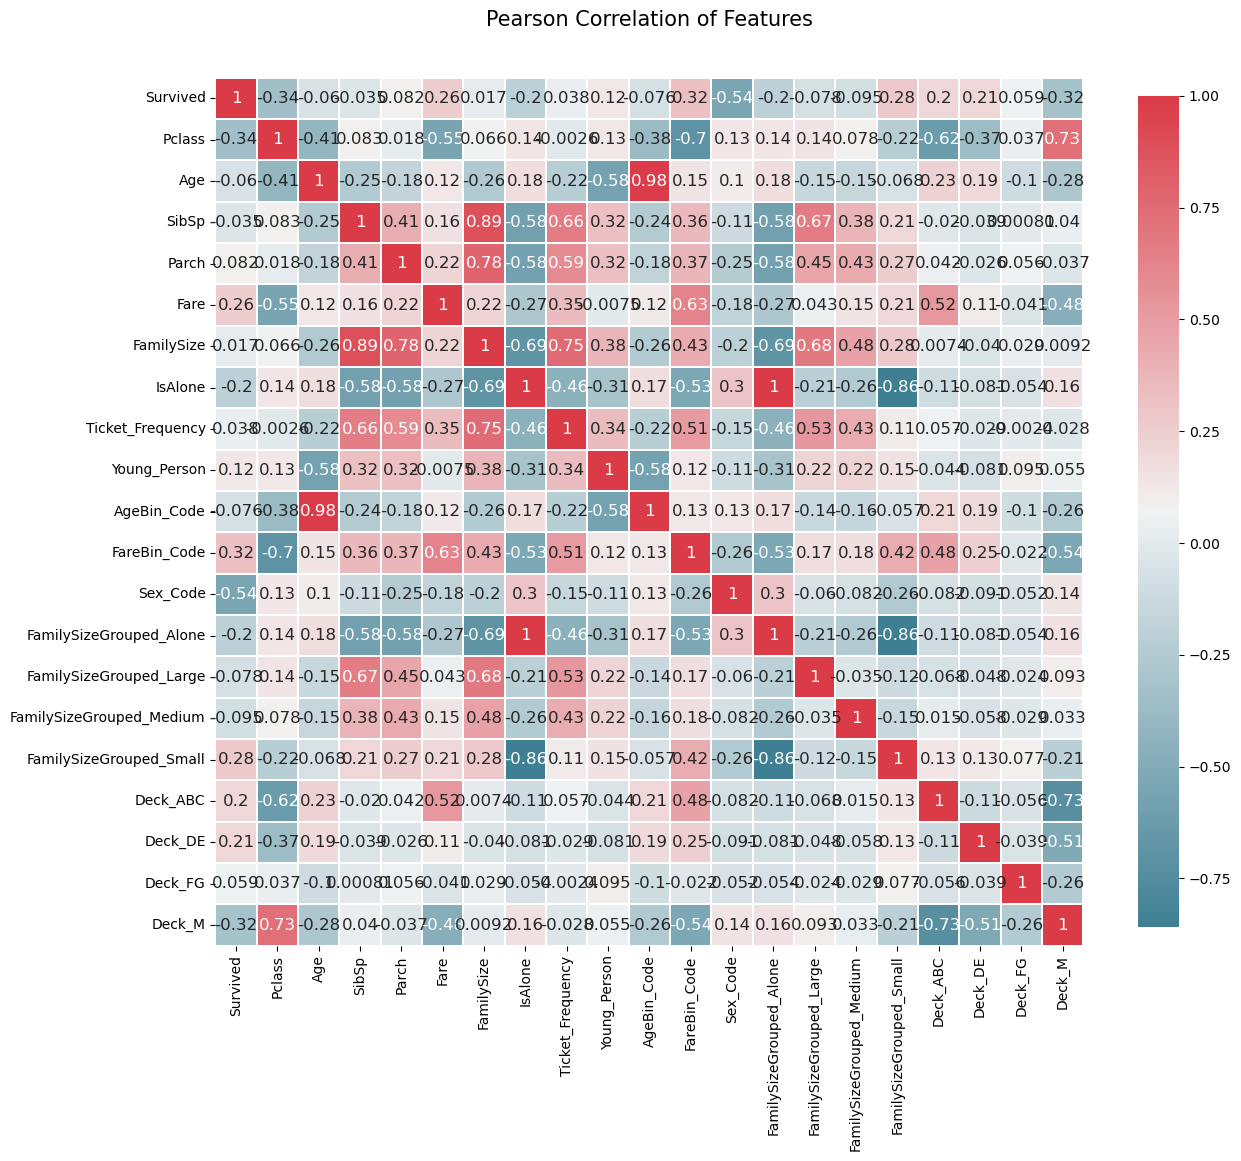

In [9]:
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(train_data)

<h1>Step 5: Applying models to the data </h1>

In [10]:
MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    #Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),
    
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),

    
    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
    XGBClassifier()    
]

#splits for cross validation
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .2, train_size = .8, random_state = 0 )

#creates table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 2*STD' ,'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

#create table to compare predictions
MLA_pred = train_data[y]
row_index = 0
#loops through each algo
for alg in MLA:
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    cv_results = model_selection.cross_validate(alg, train_data[train_x_bin], train_data[y], cv = cv_split, return_train_score=True)
    
    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()
    
    MLA_compare.loc[row_index, 'MLA Test Accuracy 2*STD'] = cv_results['test_score'].std()*2
    
    #save predictions
    alg.fit(train_data[train_x_bin], train_data[y])
    predictions = alg.predict(train_data[train_x_bin])
    MLA_pred[MLA_name] = predictions
    
    #calculate the probability of predicting 0
    unique, counts = np.unique(predictions, return_counts=True)
    pred_counts = dict(zip(unique, counts))
    pred_0_prob = pred_counts.get(0, 0) / len(predictions)
    MLA_compare.loc[row_index, 'MLA Pred 0 Prob'] = pred_0_prob
    
    row_index += 1

#print and sort table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 2*STD,MLA Time,MLA Pred 0 Prob
1,BaggingClassifier,"{'base_estimator': 'deprecated', 'bootstrap': ...",0.828371,0.824022,0.041582,0.019748,0.630752
5,GaussianProcessClassifier,"{'copy_X_train': True, 'kernel': None, 'max_it...",0.82809,0.821788,0.04619,0.228697,0.616162
21,XGBClassifier,"{'objective': 'binary:logistic', 'use_label_en...",0.828933,0.821229,0.044693,0.059309,0.630752
14,SVC,"{'C': 1.0, 'break_ties': False, 'cache_size': ...",0.828511,0.821229,0.046607,0.04469,0.630752
15,NuSVC,"{'break_ties': False, 'cache_size': 200, 'clas...",0.82486,0.82067,0.042824,0.063141,0.650954
3,GradientBoostingClassifier,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...",0.828792,0.820112,0.04234,0.077309,0.630752
4,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.828933,0.820112,0.046821,0.141295,0.630752
17,DecisionTreeClassifier,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",0.828933,0.817877,0.043904,0.00311,0.630752
18,ExtraTreeClassifier,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",0.828933,0.817318,0.046082,0.00293,0.630752
2,ExtraTreesClassifier,"{'bootstrap': False, 'ccp_alpha': 0.0, 'class_...",0.828933,0.81676,0.046014,0.118415,0.630752


<h2> 5.1: Evaluate Model Performance </h2>
<p> We want to know what accuracy is a good model performance for this subject. Since it's a binary classification problem, we know that by random guess it would be 50-50%. However, looking at the statistics of who survived, it's 67.5% of people who died. Therefore if we simply guess by all dead, we would get an accuracy of 68%. Therefore anything above 68% is a decent baseline model performance. </p>

<h3> 5.11: How would a simple handmade model do? </h3>
For this, we can use a simple decision tree that could hopefully shine light on the accuracy. To do this, we can apply a simple statistical model and relate correlations to each other, and then figure out the probability from there.

<h2> 5.12: Tuning a model with hyper-parameters </h2>
Since the random forest model did best without tuning, we can proceed to try to tune the random forest model. To do this, note how random forest essentially creates many different decision trees and then picks the average classification provided by those trees (hence the "forest"), hopefully adjusting for overcorrecting.

In [11]:
#rfc = ensemble.RandomForestClassifier(random_state=0)
#svc_classifier = svm.SVC(random_state=0)
#gbc = ensemble.GradientBoostingClassifier(random_state=0)

#param_grid = { 
#    'n_estimators': [100, 200, 300, 400, 500],
#    'max_features': ['auto', 'sqrt', 'log2'],
#    'max_depth' : [4,5,6,7,8],
#    'criterion' :['gini', 'entropy']
#}
#param_grid = {
#    'C': [0.1,1,10],
#    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
#    'gamma': ['scale', 'auto', 0.1, 0.01],
#    'degree': [2, 3, 4],
#    'class_weight': [None, 'balanced'],
#}
#param_grid = {
#    'n_estimators': [50, 100],
#    'learning_rate': [0.05, 0.1],
#    'max_depth': [3, 5],
#    'min_samples_split': [2, 5],
#    'min_samples_leaf': [1, 2],
#    'subsample': [0.8, 1.0],
#    'max_features': ['auto']
#}

#CV_rfc = model_selection.GridSearchCV(estimator=rfc, param_grid=param_grid, scoring='roc_auc', cv=cv_split)
#CV_rfc.fit(train_data[train_x_bin], train_data[y])
#CV_svc_classifier = model_selection.GridSearchCV(estimator=svc_classifier, param_grid=param_grid, scoring='roc_auc', cv=cv_split)
#CV_svc_classifier.fit(train_data[train_x_bin], train_data[y])
#CV_gbc = model_selection.GridSearchCV(estimator=gbc, param_grid=param_grid, scoring = 'roc_auc', cv=cv_split)
#CV_gbc.fit(train_data[train_x_bin], train_data[y])

In [12]:
#CV_rfc.best_params_
#CV_svc_classifier.best_params_
#CV_gbc.best_params_

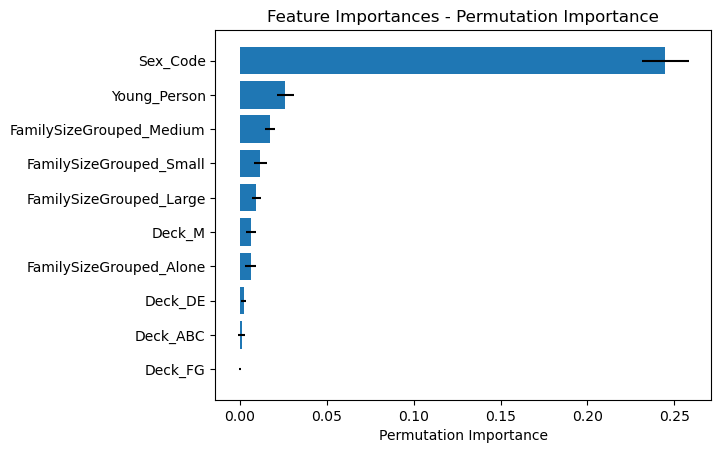

In [13]:
#printing the results
#print("The best test score: ", CV_rfc.cv_results_['mean_test_score'][CV_rfc.best_index_])
#print("The best test score (std): ", CV_rfc.cv_results_['std_test_score'][CV_rfc.best_index_])
rfc1 = ensemble.RandomForestClassifier(n_estimators=100,criterion='entropy',max_depth=5,max_features='auto')
rfc1.fit(train_data[train_x_bin], train_data[y])
svc1 = svm.SVC(C=10, class_weight='balanced', degree=2, gamma='scale', kernel='rbf') 
svc1.fit(train_data[train_x_bin], train_data[y])
gbc1 = ensemble.GradientBoostingClassifier(learning_rate= 0.1,
 max_depth= 3,
 max_features= 'auto',
 min_samples_leaf= 1,
 min_samples_split= 2,
 n_estimators= 50,
 subsample= 0.8)
gbc1.fit(train_data[train_x_bin], train_data[y])

#Edit this to see different models
result = inspection.permutation_importance(rfc1, train_data[train_x_bin], train_data[y], n_repeats=30, random_state=42)

# Visualize the feature importances
sorted_idx = result.importances_mean.argsort()

feature_names = train_data[train_x_bin].columns

# Plot the feature importances using a bar chart
plt.barh(range(len(sorted_idx)), result.importances_mean[sorted_idx], xerr=result.importances_std[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Permutation Importance')
plt.title('Feature Importances - Permutation Importance')
plt.show()

#reaffirms -> sex still important
#also family size and title code are pretty important, 

<h1>Step 6: Validate and Implement </h1>

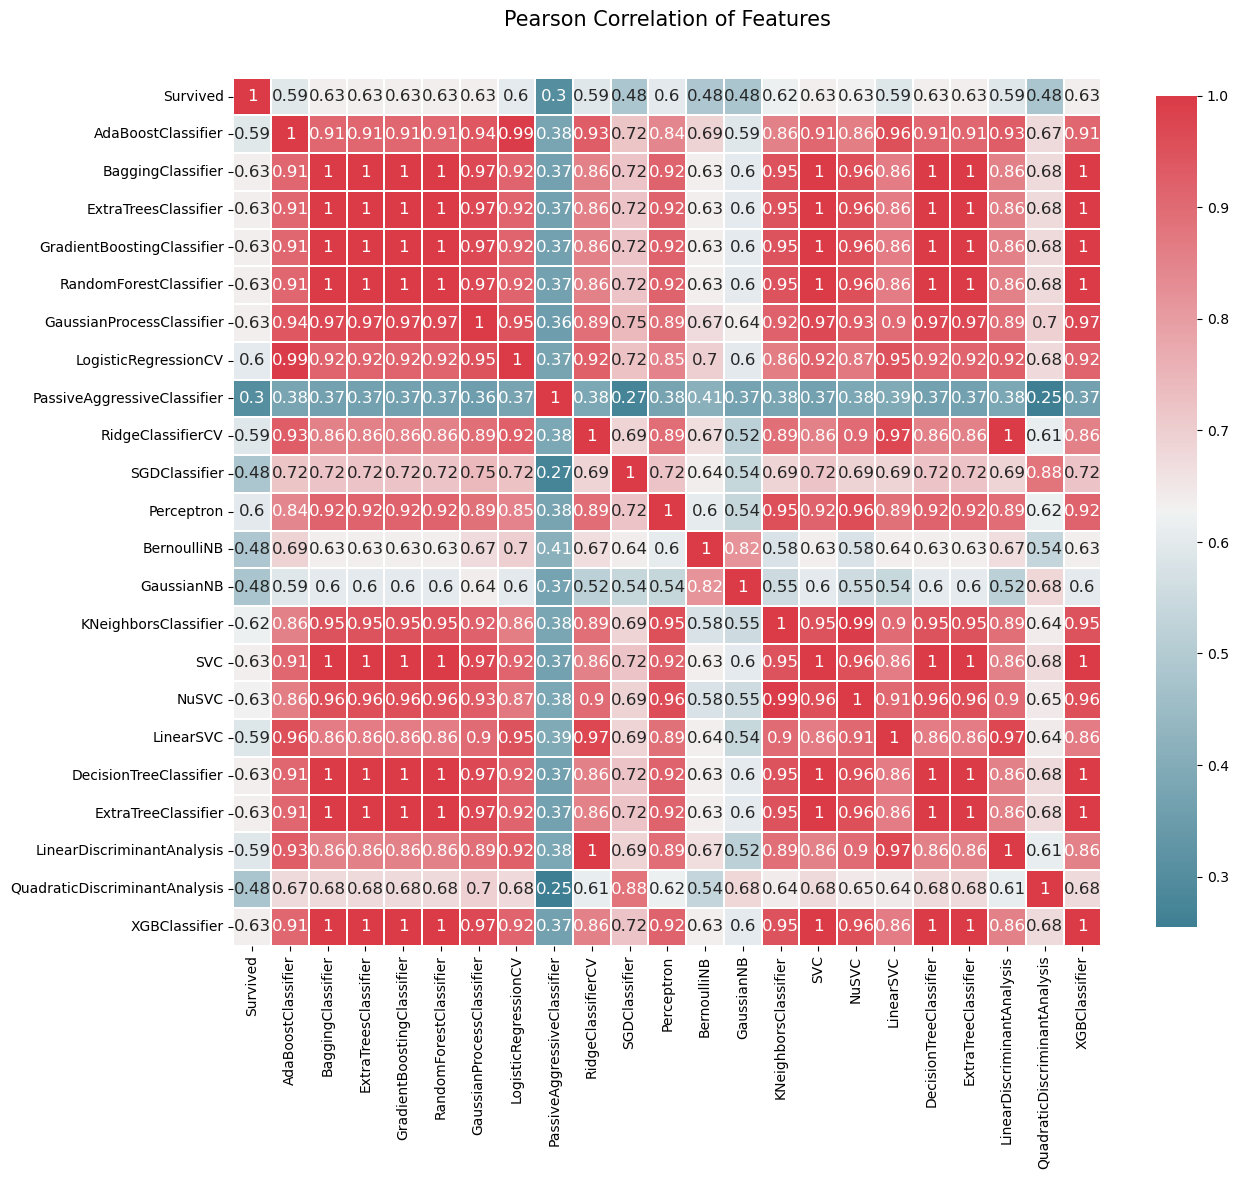

In [14]:
#compare algorithm predictions with each other
correlation_heatmap(MLA_pred)

In [15]:
#Running with a voting classifier
vote_est = [
    #Ensemble Methods: http://scikit-learn.org/stable/modules/ensemble.html
    ('ada', ensemble.AdaBoostClassifier()),
    ('bc', ensemble.BaggingClassifier()),
    ('etc',ensemble.ExtraTreesClassifier()),
    ('gbc', ensemble.GradientBoostingClassifier()),
    ('rfc', ensemble.RandomForestClassifier()),

    #Gaussian Processes: http://scikit-learn.org/stable/modules/gaussian_process.html#gaussian-process-classification-gpc
    ('gpc', gaussian_process.GaussianProcessClassifier()),
    
    #GLM: http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
    ('lr', linear_model.LogisticRegressionCV()),
    
    #Navies Bayes: http://scikit-learn.org/stable/modules/naive_bayes.html
    ('bnb', naive_bayes.BernoulliNB()),
    ('gnb', naive_bayes.GaussianNB()),
    
    #Nearest Neighbor: http://scikit-learn.org/stable/modules/neighbors.html
    ('knn', neighbors.KNeighborsClassifier()),
    
    #SVM: http://scikit-learn.org/stable/modules/svm.html
    ('svc', svm.SVC(probability=True)),
    
    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
    ('xgb', XGBClassifier())

]

#majority rules vote
vote_hard = ensemble.VotingClassifier(estimators = vote_est , voting = 'hard')
vote_hard_cv = model_selection.cross_validate(vote_hard, train_data[train_x_bin], train_data[y], cv  = cv_split, return_train_score = True)
vote_hard.fit(train_data[train_x_bin], train_data[y])

print("Hard Voting with Train Score Mean: ", vote_hard_cv['train_score'].mean())
print("Hard Voting with Test Score Mean: ", vote_hard_cv['test_score'].mean())
print("Hard Voting with Test Score 2*STD: ", vote_hard_cv['test_score'].std()*2)

Hard Voting with Train Score Mean:  0.8287921348314606
Hard Voting with Test Score Mean:  0.8223463687150838
Hard Voting with Test Score 2*STD:  0.047875497844980026


In [16]:
#Predicting and Submitting the Test Score
test_data['Survived'] = rfc1.predict(test_data[train_x_bin]) #tuned = 0.787 score
#test_data['Survived'] = svc1.predict(test_data[train_x_bin]) #tuned = 0.778 score
#test_data['Survived'] = vote_hard.predict(test_data[train_x_bin])
#test_data['Survived'] = gbc1.predict(test_data[train_x_bin])

#submit file
submit = test_data[['PassengerId','Survived']]
submit.to_csv("../working/submission.csv", index=False)

print('Validation Data Distribution: \n', test_data['Survived'].value_counts(normalize = True))
#actual distribution should be around 68% dead -> actual rate
submit.sample(10)

Validation Data Distribution: 
 0    0.602871
1    0.397129
Name: Survived, dtype: float64


,PassengerId,Survived
267,1159,0
187,1079,1
145,1037,0
274,1166,0
87,979,1
227,1119,1
201,1093,1
56,948,0
199,1091,1
209,1101,0
